Generate plot of SFNO-generated vs E3SMv2 distribution of precipitation.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

from fme_diags.histogram import compute_histograms, plot_time_mean_histogram
from fme_diags.utils import load_config, open_autoregressive_inference

_ = xr.set_options(keep_attrs=True)

In [2]:
CONFIG_KEY = "topo-lr3.00e-04"
PREDS_START_DATE = "0031-01-01"
FLIP_LAT = False
CHUNKS = {"timestep": 178}

In [3]:
config_url = load_config("./preds.yaml")[CONFIG_KEY]["url"]
ds = open_autoregressive_inference(config_url, start=PREDS_START_DATE, flip_lat=FLIP_LAT, chunks=CHUNKS)
ds

,Array,Chunk
Bytes,7.05 GiB,88.00 MiB
Shape,"(2, 1, 14597, 180, 360)","(2, 1, 178, 180, 360)"
Count,167 Tasks,83 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.05 GiB,88.00 MiB
Shape,"(2, 1, 14597, 180, 360)","(2, 1, 178, 180, 360)"
Count,167 Tasks,83 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
da = ds["surface_precipitation_rate"]

with ProgressBar():
    da = da.resample(time="1D").mean("time").compute()

[########################################] | 100% Completed |  6.0s


In [5]:
hist_range = da.min().compute().item(), da.max().compute().item()

No latitude weighting:

In [6]:
%%time

precip_hist_ds = compute_histograms(da, n_bins=300, hist_range=hist_range, lat_weighted=False)
precip_hist_ds

CPU times: user 44.7 s, sys: 0 ns, total: 44.7 s
Wall time: 44.7 s


<xarray.Dataset>
Dimensions:    (source: 2, sample: 1, time: 3649, bin_id: 300, bin_edges: 301)
Coordinates:
  * source     (source) object 'target' 'prediction'
  * sample     (sample) int64 0
  * time       (time) object 0031-01-02 00:00:00 ... 0040-12-31 00:00:00
  * bin_id     (bin_id) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * bin_edges  (bin_edges) float64 -0.000311 -0.0002765 ... 0.01001 0.01005
Data variables:
    hist       (source, sample, time, bin_id) float64 0.0 0.0 0.0 ... 0.0 0.0

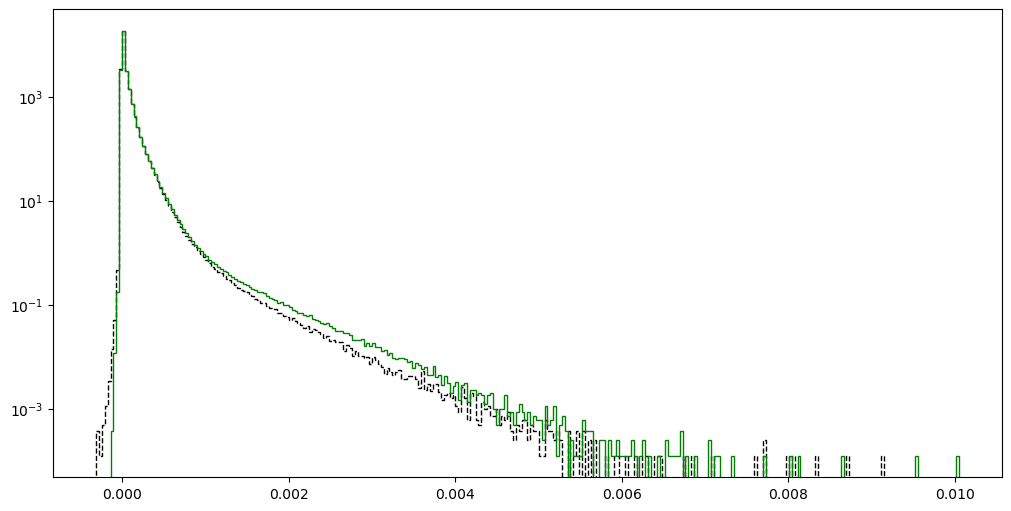

In [7]:
fig, ax = plot_time_mean_histogram(precip_hist_ds, log=True, density=True, histtype="step")
fig.show()

With latitude weighting:

In [8]:
%%time

lat_weighted_precip_hist_ds = compute_histograms(da, n_bins=300, hist_range=hist_range, lat_weighted=True)

CPU times: user 44.8 s, sys: 0 ns, total: 44.8 s
Wall time: 44.8 s


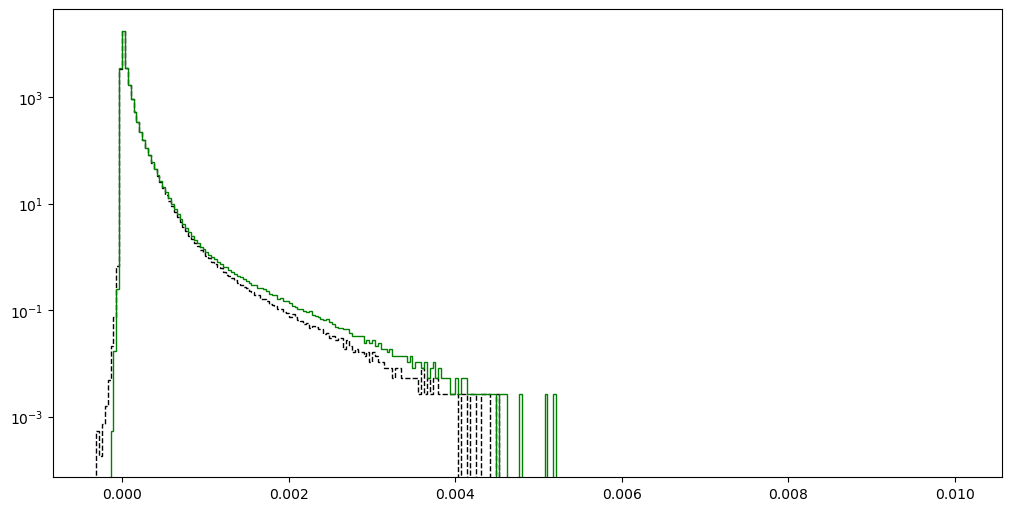

In [9]:
fig, ax = plot_time_mean_histogram(lat_weighted_precip_hist_ds, log=True, density=True, histtype="step")
fig.show()

Tropics, no latitude weighting:

In [10]:
da_tropics = da.sel(lat=slice(15, -15))
hist_range_tropics = da_tropics.min().compute().item(), da_tropics.max().compute().item()

In [11]:
%%time

precip_hist_ds_tropics = compute_histograms(da_tropics, n_bins=300, hist_range=hist_range_tropics, lat_weighted=False)
precip_hist_ds_tropics

CPU times: user 8.47 s, sys: 41.5 ms, total: 8.51 s
Wall time: 8.51 s


<xarray.Dataset>
Dimensions:    (source: 2, sample: 1, time: 3649, bin_id: 300, bin_edges: 301)
Coordinates:
  * source     (source) object 'target' 'prediction'
  * sample     (sample) int64 0
  * time       (time) object 0031-01-02 00:00:00 ... 0040-12-31 00:00:00
  * bin_id     (bin_id) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * bin_edges  (bin_edges) float64 -0.000228 -0.0001995 ... 0.008299 0.008327
Data variables:
    hist       (source, sample, time, bin_id) float64 0.0 0.0 0.0 ... 0.0 0.0

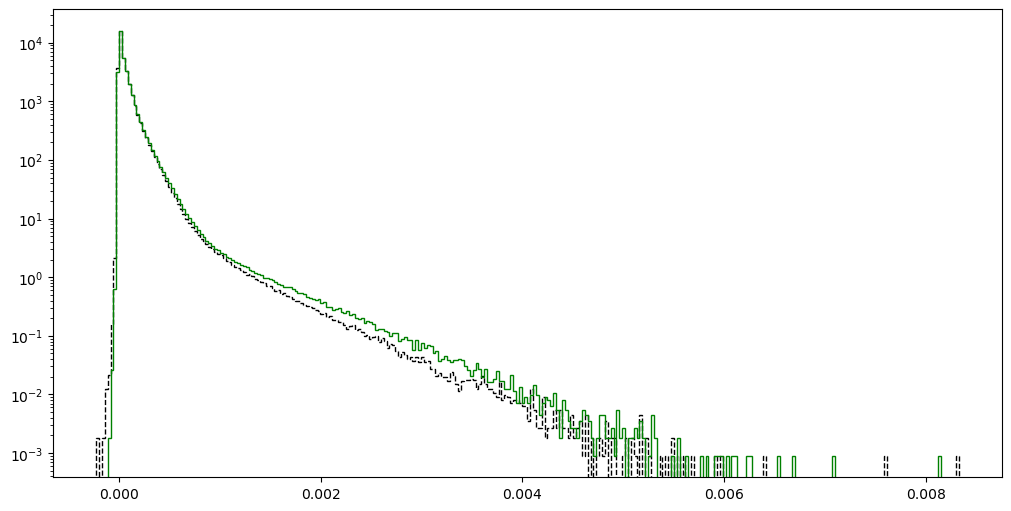

In [12]:
fig, ax = plot_time_mean_histogram(precip_hist_ds_tropics, log=True, density=True, histtype="step")
fig.show()